<a href="https://colab.research.google.com/github/fabiormazza/IA025_2022S1/blob/main/projeto_final/fabio_mazza/projeto_final_modulos12_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminar - Downloads

In [1]:
#!pip install wandb
#!wandb login

In [2]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 14.5 MB/s 
     |████████████████████████████████| 212 kB 77.7 MB/s 
     |████████████████████████████████| 1.1 MB 77.3 MB/s 
     |████████████████████████████████| 140 kB 93.2 MB/s 
     |████████████████████████████████| 101 kB 11.7 MB/s 
     |████████████████████████████████| 596 kB 92.7 MB/s 
     |████████████████████████████████| 127 kB 84.4 MB/s 
     |████████████████████████████████| 144 kB 84.1 MB/s 
     |████████████████████████████████| 271 kB 70.1 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's de

In [3]:
## Get dataset images

!wget -c http://images.cocodataset.org/zips/train2017.zip
!wget -c http://images.cocodataset.org/zips/val2017.zip

!unzip "/content/train2017.zip"
!unzip "/content/val2017.zip"

A saída de streaming foi truncada nas últimas 5000 linhas.
 extracting: val2017/000000212226.jpg  
 extracting: val2017/000000231527.jpg  
 extracting: val2017/000000578922.jpg  
 extracting: val2017/000000062808.jpg  
 extracting: val2017/000000119038.jpg  
 extracting: val2017/000000114871.jpg  
 extracting: val2017/000000463918.jpg  
 extracting: val2017/000000365745.jpg  
 extracting: val2017/000000320425.jpg  
 extracting: val2017/000000481404.jpg  
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/

In [4]:
## Get dataset annotations

!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip "/content/annotations_trainval2017.zip"

!wget http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip
!unzip "/content/stuff_annotations_trainval2017.zip"


--2022-07-13 19:28:31--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.135.201
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.135.201|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  33.8MB/s    in 7.8s    

2022-07-13 19:28:39 (31.1 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  /content/annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  
--2022-07-13 19:28:46--  http://images.cocodataset.org/anno

# Preliminar - Preparação

In [5]:
#import wandb
#wandb.init(project="image-to-label", entity="fabiormazza")

In [6]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [7]:
import collections
import itertools
import functools
import math
import random

import torch
import torch.nn as nn
from torch import Tensor
import numpy as np
from torch.utils.data import DataLoader
import tqdm

from collections import OrderedDict
from typing import List
import torchvision.transforms as transforms
import torchvision.models as models

from typing import Tuple
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.nn import TransformerDecoder, TransformerDecoderLayer
from torch.nn.modules.activation import Sigmoid

import transformers

In [8]:
# Check which GPU we are using
!nvidia-smi

Wed Jul 13 19:29:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    24W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


In [10]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
def tokenize(text: str, tokenizer=tokenizer):
    return tokenizer(text, return_tensors=None, add_special_tokens=False).input_ids

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

# DATASET

In [11]:
dataDir='/content'

## Annotations from captions train/val

aFile_captions_train='{}/annotations/captions_train2017.json'.format(dataDir) ## Annotation file - train
aFile_captions_val='{}/annotations/captions_val2017.json'.format(dataDir) ## Annotation file - validation

coco_cap_train = COCO(aFile_captions_train)
coco_cap_val = COCO(aFile_captions_val)

loading annotations into memory...
Done (t=0.95s)
creating index...
index created!
loading annotations into memory...
Done (t=0.19s)
creating index...
index created!


In [12]:
## Image transformations

transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.Lambda(lambda x: x.expand(3,-1,-1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [13]:
class MyDataset(torch.utils.data.Dataset):

  def __init__(self, img_ids: List[int], coco_cap, tokenizer, file_dir: str, transformations, max_seq_length):
    self.img_ids = img_ids
    self.coco_cap = coco_cap
    self.transformations = transformations
    self.max_seq_length = max_seq_length

    ## Inputs
    img_ids_str = list(map(str, img_ids))
    imgs = [self.transformations(io.imread(f'/content/{file_dir}/{img_ids_str[i].zfill(12)}.jpg')) for i in tqdm.notebook.tqdm(range(len(img_ids_str)))]
    
    self.inputs = imgs

    ## Inputs to Module 2
    inputs_mod2 = torch.LongTensor([])
    targets = torch.LongTensor([])
    cls = 101

    for id in tqdm.notebook.tqdm(img_ids):

      ann_id_cap = self.coco_cap.getAnnIds(id)
      anns_cap = self.coco_cap.loadAnns(ann_id_cap)
      
      caps = [anns_cap[i]['caption'] for i in range(len(anns_cap))]
      cap = caps[0] #### Start with only one example... improve later

      ids = tokenize(cap)
      ids = [cls] + ids

      if len(ids) >= self.max_seq_length:
          inpt = torch.LongTensor(ids[:self.max_seq_length])
      else:
          inpt = torch.cat((torch.LongTensor(ids), torch.zeros(self.max_seq_length - len(ids))))

      inpt = inpt.unsqueeze(0)
      inputs_mod2 = torch.cat((inputs_mod2, inpt), dim=0)
    
    self.inputs_mod2 = inputs_mod2.long()

    #Targets to Module 2
    targets = torch.roll(self.inputs_mod2, -1, dims=1)
    targets[:, -1] = 0

    self.targets = targets.long()

  def __len__(self):
    return len(self.img_ids)
  
  def __getitem__(self, idx):
    return self.inputs[idx], self.inputs_mod2[idx], self.targets[idx]

## DS - Verificação

In [14]:
## Dataset

dummy_image_ids = [391895, 522418, 184613, 318219, 554625]
dummy_dataset = MyDataset(img_ids=dummy_image_ids, coco_cap=coco_cap_train, tokenizer=tokenizer, file_dir='train2017', transformations=transformations, max_seq_length = 24)
dummy_loader = DataLoader(dummy_dataset, batch_size=5, shuffle=False)
assert len(dummy_dataset) == 5
print('Passou no assert de tamanho do dataset.')

first_batch_inputs, first_batch_inputs_mod2, first_batch_targets = next(iter(dummy_loader))

imgs_url = ['http://images.cocodataset.org/train2017/000000391895.jpg',
 'http://images.cocodataset.org/train2017/000000522418.jpg',
 'http://images.cocodataset.org/train2017/000000184613.jpg',
 'http://images.cocodataset.org/train2017/000000318219.jpg',
 'http://images.cocodataset.org/train2017/000000554625.jpg']

correct_first_batch_inputs = torch.tensor([])

for i in range(len(imgs_url)):
  correct_first_batch_inputs = torch.cat((correct_first_batch_inputs, transformations(io.imread(imgs_url[i]))), dim=0)

correct_first_batch_inputs = correct_first_batch_inputs.view(5, 3, 224, 224)
correct_first_batch_inputs = torch.FloatTensor(correct_first_batch_inputs)

assert torch.equal(first_batch_inputs, correct_first_batch_inputs)
print('Passou no assert do input do dataset')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Passou no assert de tamanho do dataset.
Passou no assert do input do dataset


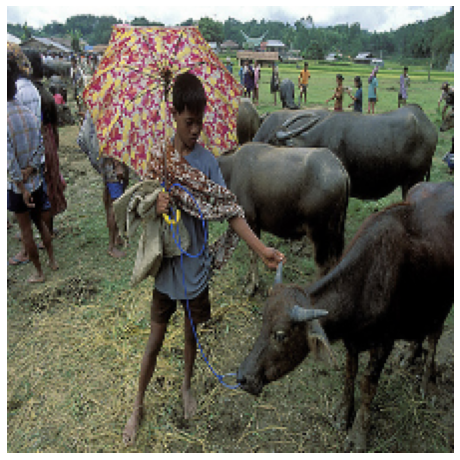

In [15]:
## Verificação de um item do batch do dataset (input e target)
n = 2
img, dummy_inputs_mod2, dummy_targets = dummy_dataset[n]

inv_trans = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),
                               ])
plt.axis('off')
plt.imshow(inv_trans(img).permute(1, 2, 0))
plt.show()

In [16]:
print(tokenizer.convert_ids_to_tokens(first_batch_inputs_mod2[n]))
first_batch_inputs_mod2

['[CLS]', 'A', 'child', 'holding', 'a', 'flower', '##ed', 'umbrella', 'and', 'pet', '##ting', 'a', 'ya', '##k', '.', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


tensor([[  101,   138,  1299,  1114,   170,  1894, 10815,  1113,   170,  1353,
           182, 15680,  1113,   170,  6786,  1812,   119,     0,     0,     0,
             0,     0,     0,     0],
        [  101,   138,  1590,  3351,   170,  5795,  1113,  1123,  1246,  5910,
           170, 10851,   119,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0],
        [  101,   138,  2027,  2355,   170,  7366,  1174, 14793,  1105, 11109,
          1916,   170, 11078,  1377,   119,     0,     0,     0,     0,     0,
             0,     0,     0,     0],
        [  101,   138,  1685,  2298,  2288,  1107,  1524,  1104,   170,  2775,
          9303,   119,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0],
        [  101,   170,  2298,  3351,  1246, 16215,  1606,  1141,  2775,  1107,
           170,  1263,  5105,  1104,  7565,     0,     0,     0,     0,     0,
             0,     0,     0,     0]])

In [17]:
print(tokenizer.convert_ids_to_tokens(first_batch_targets[n]))

['A', 'child', 'holding', 'a', 'flower', '##ed', 'umbrella', 'and', 'pet', '##ting', 'a', 'ya', '##k', '.', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


# DS - Carregamento do Dataset

In [22]:
########### MAX SEQ LENGTH ###############
max_seq_length = 24

##Número de exemplos do dataset
all_img_ids_train = coco_cap_train.getImgIds()
all_img_ids_val_test = coco_cap_val.getImgIds()

data_train_ex_num = len(all_img_ids_train)
data_valid_ex_num = int(len(all_img_ids_val_test) / 2) #validation coco dataset was divided in two sets, one being used as val and other as test (test set is not used in validation or training)
data_test_ex_num = int(len(all_img_ids_val_test) / 2)
all_ex_num = data_train_ex_num + data_valid_ex_num + data_test_ex_num

## Número de exemplos (truncado ou não)
train_ex_num = 50_000 #50_000
valid_ex_num = 2_500 #2_500
test_ex_num = 2_500 #2_500

max_lines = train_ex_num + valid_ex_num + test_ex_num

print(f"Number of examples used: {max_lines}; Number of examples in the dataset: {all_ex_num}")

## Carregamento do Dataset

img_ids_train = all_img_ids_train[:train_ex_num]
img_ids_val = all_img_ids_val_test[:valid_ex_num]
img_ids_test = all_img_ids_val_test[valid_ex_num:valid_ex_num + test_ex_num]

print(f"Train: {len(img_ids_train)}, Valid: {len(img_ids_val)}, Test: {len(img_ids_test)}")

valid_dataset = MyDataset(img_ids=img_ids_val, coco_cap=coco_cap_val, tokenizer=tokenizer, file_dir='val2017', transformations=transformations, max_seq_length=max_seq_length)
test_dataset = MyDataset(img_ids=img_ids_test, coco_cap=coco_cap_val, tokenizer=tokenizer, file_dir='val2017', transformations=transformations, max_seq_length=max_seq_length)

train_dataset = MyDataset(img_ids=img_ids_train, coco_cap=coco_cap_train, tokenizer=tokenizer, file_dir='train2017', transformations=transformations, max_seq_length=max_seq_length)

Number of examples used: 55000; Number of examples in the dataset: 123287
Train: 50000, Valid: 2500, Test: 2500


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

# MODELO

## Módulo 1

In [23]:
class MultiLabelClassifier(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.backbone = models.resnet34(pretrained=True)
        self.model_1_wo_fc = nn.Sequential(*(list(self.backbone.children())[:-1])).to(device)

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.20),
            nn.Linear(in_features=512, out_features=1024), 
            nn.Dropout(p=0.20),
            nn.Linear(in_features=1024, out_features=3072), ### 3072 = max_seq_len = 24 x embedding_dim(d_model = 128)
        ).to(device)
    
    def forward(self, input):
        y_hat = self.model_1_wo_fc(input)
        y_hat = torch.flatten(y_hat, 1)
        output = self.classifier(y_hat)

        return output

## Módulo 2

In [24]:
class LanguageModel(torch.nn.Module):

    def __init__(self, vocab_size: int, max_seq_length: int, embedding_dim: int, nhead: int, 
                 num_encoder_layers: int, num_decoder_layers: int, dim_feedforward: int, n_linear: int, dropout: float = 0.1, pad_token_id: int = 0):

        super(LanguageModel, self).__init__()

        self.num_embeddings = vocab_size
        self.max_seq_length = max_seq_length
        self.d_model = embedding_dim
        self.nhead = nhead
        self.num_encoder_layers = num_encoder_layers
        self.num_decoder_layers = num_decoder_layers
        self.dim_feedforward = dim_feedforward
        self.n_linear = n_linear
        self.dropout = dropout
        self.pad_token_id = pad_token_id

        #Target causal mask
        causal_mask = torch.ones((self.max_seq_length, self.max_seq_length), dtype=torch.bool)
        causal_mask = torch.triu(causal_mask, diagonal=1)

        self.tgt_mask = causal_mask.to(device)

        self.embedding_decoder = torch.nn.Embedding(self.num_embeddings, self.d_model, device=device)
        self.positional_decoder = torch.nn.Parameter(torch.randn(self.max_seq_length, self.d_model, device=device)/1000000)

        self.transformer = torch.nn.Transformer(d_model=self.d_model, nhead=self.nhead, num_encoder_layers=self.num_encoder_layers, num_decoder_layers=self.num_decoder_layers, 
                               dim_feedforward=self.dim_feedforward, dropout=self.dropout, batch_first=True, device=device)
        
        self.linear = nn.Sequential(OrderedDict([
                              ('l1', torch.nn.Linear(self.d_model, self.n_linear, device=device)),
                              ('relu', torch.nn.ReLU()),
                              ('dropout', torch.nn.Dropout(p=0.20)),
                              ('l2', torch.nn.Linear(self.n_linear, self.num_embeddings, device=device, bias = False))
        ]))
    
    def forward(self, input_en, input_de):
        
        #Pad Mask
        decoder_pad_mask = input_de == self.pad_token_id
        decoder_pad_mask.to(device)
        #Decoder
        Y_de = self.embedding_decoder(input_de)
        Y_de = Y_de + self.positional_decoder

        #Encoder
        X_en = input_en.reshape(-1, self.max_seq_length, self.d_model)
        #X_en = torch.zeros((input_en.shape[0], self.max_seq_length, self.d_model), device=device) ###### Used when encoder is zero
                
        output_decoder = self.transformer(src=X_en, tgt=Y_de, tgt_mask=self.tgt_mask, tgt_key_padding_mask=decoder_pad_mask)
        
        output = self.linear(output_decoder)

        return output

# TREINAMENTO

In [ ]:
max_examples = 1_000_000
eval_every_steps = 1000
lr = 1e-4

embedding_dim = 128
nhead = 4
num_encoder_layers = 4
num_decoder_layers = 4
dim_feedforward = 1024
n_linear = 1024

model_1 = MultiLabelClassifier().to(device)

model_2 = LanguageModel(vocab_size=tokenizer.vocab_size, max_seq_length=max_seq_length, embedding_dim=embedding_dim, nhead=nhead, 
                 num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers, dim_feedforward=dim_feedforward, n_linear=n_linear).to(device)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
validation_loader = DataLoader(valid_dataset, batch_size=64, drop_last=True)

optimizer = torch.optim.Adam(list(model_1.parameters()) + list(model_2.parameters()), lr=lr)

def train_step(inputs, inputs_mod2, targets): #Inputs_mod2 are for the decoder
    model_1.train()
    model_2.train()
    model_1.zero_grad()
    model_2.zero_grad()

    inputs2_en = model_1(inputs) #inputs2_en will be fed to the encoder of model #2

    # Model loss
    logits = model_2(inputs2_en, inputs_mod2)
    logits = logits.reshape(-1, logits.shape[-1])
    targets = targets.reshape(-1)
    loss = nn.functional.cross_entropy(logits, targets, ignore_index=model_2.pad_token_id)

    loss.backward()
    optimizer.step()

    return loss.item()

def validation_step(inputs, inputs_mod2, targets):
    model_1.eval()
    model_2.eval()
    
    inputs2_en = model_1(inputs) #inputs2_en will be fed to the encoder of model #2

    # Model loss
    logits = model_2(inputs2_en, inputs_mod2)
    logits = logits.reshape(-1, logits.shape[-1])
    targets = targets.reshape(-1)
    loss = nn.functional.cross_entropy(logits, targets, ignore_index=model_2.pad_token_id)

    return loss.item()

train_losses = []

n_examples = 0
step = 0

while n_examples < max_examples:
    for (train_inputs, train_inputs_mod2, train_targets) in train_loader: 
        loss = train_step(train_inputs.to(device), train_inputs_mod2.to(device), train_targets.to(device)) 
        train_losses.append(loss)

        if step % eval_every_steps == 0:
            train_ppl = np.exp(np.average(train_losses))
            
            valid_loss = 0
            best_valid_loss = np.inf

            with torch.no_grad():
                for (val_inputs, val_inputs_mod2, val_targets) in validation_loader:
                    valid_step_loss = validation_step(val_inputs.to(device), val_inputs_mod2.to(device), val_targets.to(device))
                    valid_loss += valid_step_loss/len(validation_loader)

                if valid_loss < best_valid_loss:
                    torch.save(model_1.state_dict(), 'best_model1_parameters.pt')
                    torch.save(model_2.state_dict(), 'best_model2_parameters.pt')
                    print('Models parameters saved.')
                    best_valid_loss = valid_loss

                valid_ppl = np.exp(valid_loss)

            print(f'{step} steps; {n_examples} examples so far; TRAIN PPL: {train_ppl:.2f}, VALID PPL: {valid_ppl:.2f}')
            
            train_losses = []

        #wandb.log({'train loss:': train_loss, 'valid loss:': valid_loss, 'train_loss1:': train_loss1, 'train_loss2:': train_loss2, 'train_loss3:': train_loss3, 
        #    'valid_loss1:': valid_loss1, 'valid_loss2:': valid_loss2, 'valid_loss3:':valid_loss3})

        n_examples += len(train_inputs)  # Increment of batch size
        step += 1
        if n_examples >= max_examples:
            break


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Models parameters saved.
0 steps; 0 examples so far; TRAIN PPL: 29686.13, VALID PPL: 25776.13
Models parameters saved.
1000 steps; 64000 examples so far; TRAIN PPL: 85.61, VALID PPL: 36.33
Models parameters saved.
2000 steps; 128000 examples so far; TRAIN PPL: 29.70, VALID PPL: 25.78
Models parameters saved.
3000 steps; 192000 examples so far; TRAIN PPL: 21.78, VALID PPL: 22.10
Models parameters saved.
4000 steps; 256000 examples so far; TRAIN PPL: 17.84, VALID PPL: 20.18
Models parameters saved.
5000 steps; 320000 examples so far; TRAIN PPL: 15.09, VALID PPL: 19.32
Models parameters saved.
6000 steps; 384000 examples so far; TRAIN PPL: 13.47, VALID PPL: 18.95
Models parameters saved.
7000 steps; 448000 examples so far; TRAIN PPL: 12.15, VALID PPL: 19.04
Models parameters saved.
8000 steps; 512000 examples so far; TRAIN PPL: 10.90, VALID PPL: 19.31
Models parameters saved.
9000 steps; 576000 examples so far; TRAIN PPL: 10.01, VALID PPL: 19.81
Models parameters saved.
10000 steps; 64000

# TESTE

In [ ]:
model_1 = MultiLabelClassifier(num_cats=num_cats).to(device)

model_2 = LanguageModel(vocab_size, max_seq_length, embedding_dim, nhead, 
                 num_encoder_layers, num_decoder_layers, dim_feedforward, n_linear).to(device)

model_1.load_state_dict(torch.load('/content/best_model1_parameters.pt'))
model_2.load_state_dict(torch.load('/content/best_model2_parameters.pt'))

<All keys matched successfully>

In [ ]:
test_loader1 = DataLoader(test_dataset1, batch_size=64, drop_last=True)
test_loader2 = DataLoader(test_dataset2, batch_size=64, drop_last=True)

test_loss = 0
test_loss1 = 0
test_loss2 = 0

with torch.no_grad():
    for (test_inputs1, test_targets1), (test_inputs2, test_targets2) in zip(test_loader1, test_loader2):
        test_step_loss, test_step_loss1, test_step_loss2 = validation_step(test_inputs1.to(device), test_targets1.to(device), test_inputs2.to(device), test_targets2.to(device))
        test_loss += test_step_loss/len(test_loader1)
        test_loss1 += test_step_loss1/len(test_loader1)
        test_loss2 += test_step_loss2/len(test_loader2)

print(f'test loss: {test_loss:.4f}, test loss 1: {test_loss1:.4f}, test_loss2: {test_loss2:.4f}')


test loss: 2.8285, test loss 1: 0.1499, test_loss2: 0.2120


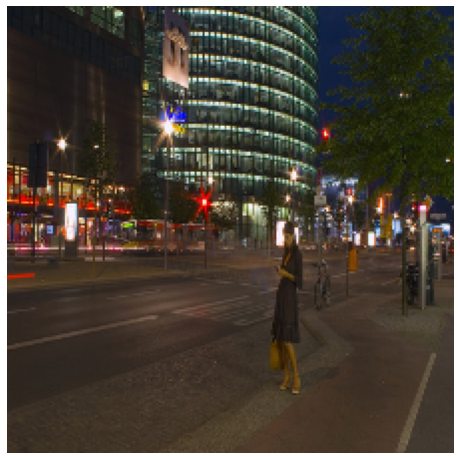

Categorias - TARGET
person ,  bicycle ,  motorcycle ,  traffic light ,  handbag ,  cell phone ,  building-other ,  metal ,  pavement ,  road ,  sky-other ,  skyscraper ,  tree ,  other ,  
 Categorias - Classificação do modelo
person ,  car ,  bus ,  traffic light ,  handbag ,  building-other ,  light ,  metal ,  pavement ,  road ,  sky-other ,  skyscraper ,  other ,  

In [ ]:
## Teste com exemplo de teste

inv_trans = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),
                               ])

img, cats = next(iter(test_loader1))
img = img[29]
cats = cats[29]

## Image categories (image from the test_loader)
cats = torch.nonzero(cats).squeeze(1).numpy()
plt.axis('off')
plt.imshow(inv_trans(img).permute(1, 2, 0))
plt.show()

cats_inst_ids = cats[cats <= 91]
cats_inst = coco_inst_val.loadCats(cats_inst_ids)
cats_stuff_ids = cats[cats > 91]
cats_stuff = coco_stuff_val.loadCats(cats_stuff_ids)

print('Categorias - TARGET')
for i in range(len(cats_inst)):
    print(cats_inst[i]['name'], ', ', end=' ')

for i in range(len(cats_stuff)):
    print(cats_stuff[i]['name'], ', ', end=' ')

## Image predicted categories
model_1.eval()
img = img.to(device)
img = img.unsqueeze(0)
cats_predicted, inputs_to_model2 = model_1(img)
threshold = 0.35
cats_predicted[cats_predicted >= threshold] = 1
cats_predicted[cats_predicted < threshold] = 0
cats_predicted = cats_predicted.squeeze()
cats_predicted = torch.nonzero(cats_predicted).squeeze(1).cpu().numpy()

cats_predicted_inst_ids = cats_predicted[cats_predicted <= 91]
cats_predicted_inst = coco_inst_val.loadCats(cats_predicted_inst_ids)
cats_predicted_stuff_ids = cats_predicted[cats_predicted > 91]
cats_predicted_stuff = coco_stuff_val.loadCats(cats_predicted_stuff_ids)

print('\n Categorias - Classificação do modelo')
for i in range(len(cats_predicted_inst)):
    print(cats_predicted_inst[i]['name'], ', ', end=' ')

for i in range(len(cats_predicted_stuff)):
    print(cats_predicted_stuff[i]['name'], ', ', end=' ')


In [ ]:
max_output_tokens = 12
model_2.eval()
input_ids = torch.zeros(max_seq_length, dtype=torch.int64)
input_ids[0] = 101

for i in range(max_output_tokens):
    logits = model_2(inputs_to_model2.to(device), input_ids.unsqueeze(dim=0).to(device))
    logits = logits[:, 1, :] # Usamos apenas o ultimo token da sequencia
    predicted_id = torch.argmax(logits).item()
    input_ids[i] = predicted_id
    output = tokenizer.decode(input_ids)
    print(output)

of [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
of, [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
of, and [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
of, and and [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
of, and and and [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
of, and and and and [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
of, and and and and and [PAD] [PAD] [PAD] [PAD] [PAD]
of, and and and and and and [PAD] [PAD] [PAD] [PAD]
of, and and and and and and and [PAD] [PAD] [PAD]
of, and and and and and and and and [PAD] [PAD]
of, and and and and and and and and and [PAD]
of, and and and and and and and and and and


In [ ]:
prompt = 'The first Seattle Open was held 86 years ago in 1936 at'# Inglewood Golf Club in Kenmore in early August. Macdonald Smith won'
max_output_tokens = 20
model_2.eval()

for _ in range(max_output_tokens):
    input_ids = tokenize(text=prompt, tokenizer=tokenizer)
    input_ids_truncated = input_ids[-max_seq_length:]  # Usamos apenas os últimos <max_seq_length> tokens como entrada para o modelo.
    logits = model_2(inputs_to_model2.to(device), torch.LongTensor([input_ids_truncated]).to(device))
    logits = logits[:, -1, :]  # Usamos apenas o ultimo token da sequencia
    # Ao usarmos o argmax, a saída do modelo em cada passo é o token de maior probabilidade.
    # Isso se chama decodificação gulosa (greedy decoding).
    predicted_id = torch.argmax(logits).item()
    input_ids += [predicted_id]  # Concatenamos a entrada com o token escolhido nesse passo.
    prompt = tokenizer.decode(input_ids)
    print(prompt)

The first Seattle Open was held 86 years ago in 1936 at the
The first Seattle Open was held 86 years ago in 1936 at the time
The first Seattle Open was held 86 years ago in 1936 at the time of
The first Seattle Open was held 86 years ago in 1936 at the time of the
The first Seattle Open was held 86 years ago in 1936 at the time of the United
The first Seattle Open was held 86 years ago in 1936 at the time of the United States
The first Seattle Open was held 86 years ago in 1936 at the time of the United States,
The first Seattle Open was held 86 years ago in 1936 at the time of the United States, and
The first Seattle Open was held 86 years ago in 1936 at the time of the United States, and the
The first Seattle Open was held 86 years ago in 1936 at the time of the United States, and the first
The first Seattle Open was held 86 years ago in 1936 at the time of the United States, and the first of
The first Seattle Open was held 86 years ago in 1936 at the time of the United States, and t